In [67]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

import io
import PIL.Image, PIL.ImageDraw

import requests

import einops
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

# Notebook dependencies
from IPython.display import clear_output, Image

from original_utils import *

import importlib
import sys
importlib.reload(sys.modules['original_utils'])
from original_utils import *

device_id = 2
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

device is cuda:2


In [2]:
# Parameters

CHANNEL_N = 16
TARGET_PADDING = 16
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🛩"

USE_PATTERN_POOL = True # set in "persistent" mode

# Load target image
target_img = load_emoji(TARGET_EMOJI)

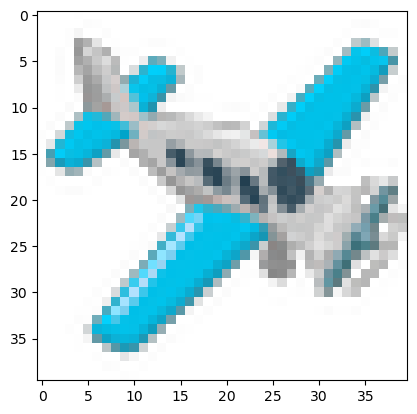

In [89]:
plt.imshow(target_img)
plt.show()

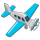

In [4]:
imshow(target_img)

In [42]:
# Define Model

class CAModel(nn.Module):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    conv1 = nn.Conv2d(in_channels=self.channel_n*3, out_channels=128, kernel_size=1)
    conv2 = nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    
    # Apply "do-nothing" initial behavior
    # torch.nn.init.xavier_uniform_(conv1.weight) # default to how tensorflow initializes the weights
    torch.nn.init.zeros_(conv2.weight)
    torch.nn.init.zeros_(conv1.bias)
    torch.nn.init.zeros_(conv2.bias)

    self.dmodel = nn.Sequential(
        conv1,
        nn.ReLU(),
        conv2,
    )
    
  def perceive(self, x, angle=0.0):
    """Pytorch does convolutions differently. Reshape accordingly
      input is (batch, in_channels, H, W)
      kernel is (filter_height, filter_width, in_channels, channel_multiplier) in TF
      but should be (out_channels, in_channels / groups, H, W) in Torch"""
    identify = torch.as_tensor([0, 1, 0], dtype=torch.float32)
    identify = torch.outer(identify, identify)
    dx = torch.as_tensor(np.outer([1, 2, 1], [-1, 0, 1]) / 8.0, dtype=torch.float32) # Sobel filter
    dy = dx.T
    c, s = torch.cos(torch.tensor(angle)), torch.sin(torch.tensor(angle))
    stacked_filters = torch.stack((identify, c*dx-s*dy, s*dx+c*dy)).to(device)
    kernel = torch.repeat_interleave(stacked_filters, self.channel_n, dim=0).view(self.channel_n*3, 1, 3, 3)
    y = F.conv2d(x, kernel, padding='same', groups=self.channel_n)
    return y

  def forward(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    x = torch.permute(x, (0, 3, 1, 2)) # make it shape [batch_size, in_channels, H, W]
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle) # y should be on device
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = torch.rand(x[:, :1, :, :].shape, device=device, dtype=torch.float32) <= fire_rate
    x = x + dx * update_mask

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    result = x * life_mask
    return torch.permute(result, (0, 2, 3, 1)) # send it back [batch_size, H, W, in_channels]

CAModel().dmodel

Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)

seed shape is torch.Size([72, 72, 16])


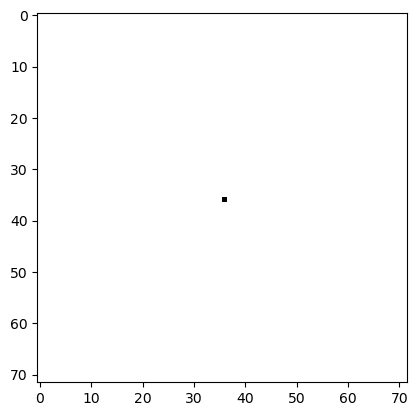

In [6]:
# Make training sample

p = TARGET_PADDING
target_img_tensor = torch.tensor(target_img)
pad_target = torch.nn.functional.pad(target_img_tensor, (0, 0, p, p, p, p))
h, w = pad_target.shape[:2]
seed = torch.zeros(h, w, CHANNEL_N, dtype=torch.float32)
seed[h//2, w//2, 3:] = 1.0
print(f'seed shape is {seed.shape}')

plt.imshow(seed[..., :4])
plt.show()

In [7]:
test_load = load_ca_model(CAModel, "vanilla_ca")

In [8]:
torch.cuda.current_device()
seed.get_device()

-1

In [9]:
x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
print(seed.shape)
print(x0.shape)
print(x0.dtype, seed.dtype)
print(x0.min(), x0.max(), seed.min(), seed.max())

torch.Size([72, 72, 16])
torch.Size([8, 72, 72, 16])
torch.float32 torch.float32
tensor(0.) tensor(1.) tensor(0.) tensor(1.)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:55<00:00,  1.53it/s]


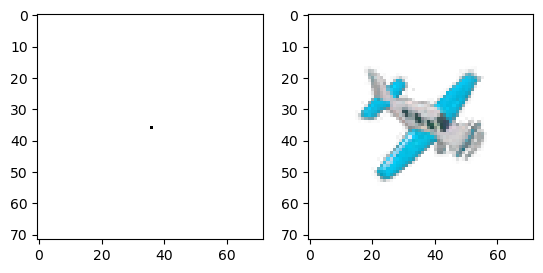

In [10]:
x = simulate_model(test_load, seed.unsqueeze(0), 85, device=device)

In [106]:
seed.shape

torch.Size([72, 72, 16])

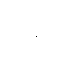

In [108]:
# plt.imshow(x_norm[0, ..., :4])
imshow(clip_tensor(x0)[0, ..., :4])

In [40]:
class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    # print(f"slot names: {self._slot_names}")
    # print(f"slot values: {list(slots.values())[0].shape}")
    # print(f"slot items: {slots.items()}")
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      # setattr(self, k, np.asarray(v))
      setattr(self, k, v)        

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

In [74]:
# Training Sequence

class Train:
  def __init__(self, ca_model, seed, target, lr=2e-3):
    """Initialize training object with model to train, seed and target
    
    :param ca_model: PyTorch model class object (instantiated)
    :param seed: PyTorch tensor of shape (H, W, C), initial seed to start training
    :param target: PyTorch tensor of shape (H, W, C), target image to learn
    """
    self.ca = ca_model
    self.seed = seed
    # Augment target tensor with batch dimension
    self.target = torch.repeat_interleave(target[None, ...], BATCH_SIZE, dim=0)
    self.lr = lr
    
    # Initialize optimizer with lr scheduler
    self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr)
    # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optim, step_size=2000, gamma=0.1)    
    self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optim, milestones=[1500], gamma=0.25)
    
    # Use library MSELoss
    self.loss_f = nn.MSELoss()
    
    # Pool of training samples for "persistent" training mode
    # self.pool = SamplePool(x=np.repeat(self.seed.detach().cpu()[None, ...], POOL_SIZE, 0))
    self.pool = SamplePool(x=torch.repeat_interleave(self.seed[None, ...], POOL_SIZE, dim=0))

    # Log the training progress
    self.loss_log = []

  def train(self, n_steps=1001):
    """Train the model stored in `self.ca` for `n_steps` training steps

    :param n_steps: int, Number of training steps
    :return: list, loss history 
    """
    for i in range(n_steps):

      # Very similar to original TF implementation
      if USE_PATTERN_POOL:
        batch = self.pool.sample(BATCH_SIZE)
        x0 = batch.x.detach() # this computes grads by default, not sure why (hence the .detach())
        
        loss_rank = self._loss_f(x0, self.target).argsort(descending=True)
        x0 = x0[list(loss_rank.detach().cpu().numpy())]
        x0[:1] = seed # to prevent catastrophic forgetting
      else:
        x0 = torch.repeat_interleave(self.seed[None, ...], BATCH_SIZE, 0)
    
      # print(f"\n x0 type is {type(x0)} and shape is {x0.shape} and device is {x0.get_device()} and requires grad: {x0.requires_grad}")

      # Run through a single training step of the model
      x, loss = self._train_step(x0)
      self.loss_log.append(loss)
      # print(f'loss log is {self.loss_log}')
    
      # Update pool
      if USE_PATTERN_POOL:
        batch.x[:] = x
        batch.commit()

      # Printing
      if i % 100 == 0:
        clear_output()

        # Visualize batch
        visualize_batch(x0.detach().cpu(), x.detach().cpu(), i)
        
        # Plot loss
        plot_loss(self.loss_log)
        
        # Export model
        # TODO

      print('\r step: %d, log10(loss): %.3f'%(len(self.loss_log), np.log10(loss)), end='')

    return self.loss_log
    
  def _train_step(self, x):
    """Perform the update step some random number of times"""

    iter_n = np.random.randint(64, 97, dtype=np.int32)
    for _ in range(iter_n):
      # Forward pass of model
      x = self.ca(x)

    # Compute loss
    # loss = self.loss_f(to_rgba(x), self.target)
    loss = self._loss_f(x, self.target).mean()

    # Compute gradients
    loss.backward()
    
    # Apply L2 normalization to parameter gradients as per original paper
    for p in self.ca.parameters():
      if p.grad is not None:
        p.grad = p.grad / (p.grad.norm() + 1e-8) 
        
    # Update parameters
    self.optim.step()
    
    # Clear previous gradients accumulated on parameters
    self.optim.zero_grad()

    # Update learning rate step
    self.scheduler.step()

    return x, loss.item()

  def _loss_f(self, output, target):
    return torch.square(to_rgba(output) - target).mean(dim=(-2, -3, -1))


In [75]:
USE_PATTERN_POOL=True

batch (before/after):


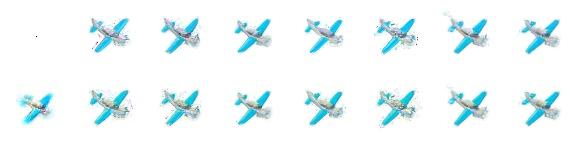

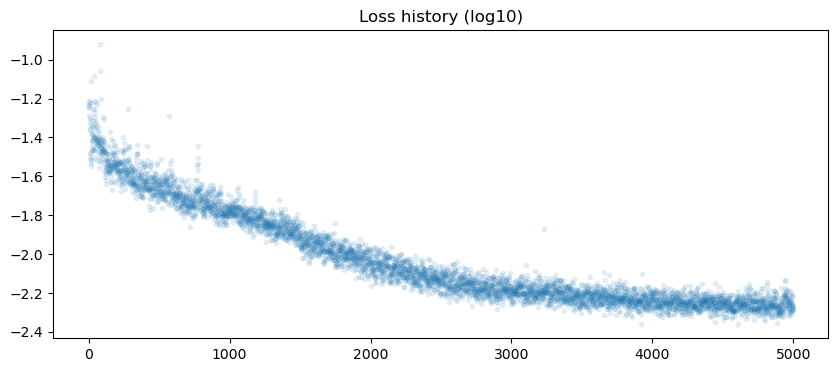

 step: 5001, log10(loss): -2.217CPU times: user 22min 50s, sys: 28.5 s, total: 23min 18s
Wall time: 22min 5s


In [76]:
%%time
# original torch conv layer initialization WITH weight decay

ca = CAModel().to(device)
train = Train(ca, seed.to(device), pad_target.to(device))

loss_log = train.train(n_steps=5001)

batch (before/after):


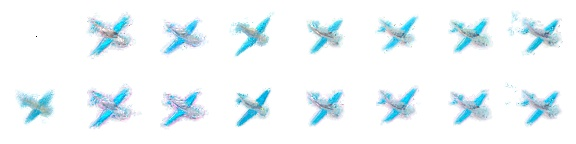

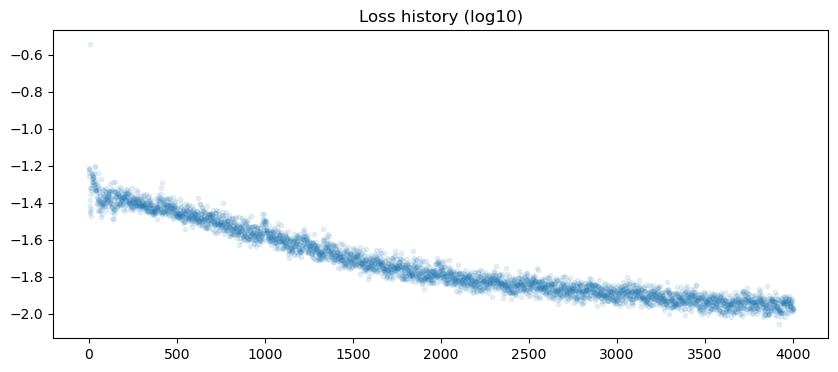

 step: 4001, log10(loss): -1.973CPU times: user 20min 32s, sys: 25 s, total: 20min 57s
Wall time: 22min 36s


In [33]:
%%time
# original torch conv layer initialization WITH weight decay

ca = CAModel().to(device)
train = Train(ca, seed.to(device), pad_target.to(device))

loss_log = train.train(n_steps=5001)

batch (before/after):


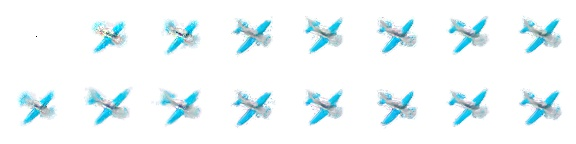

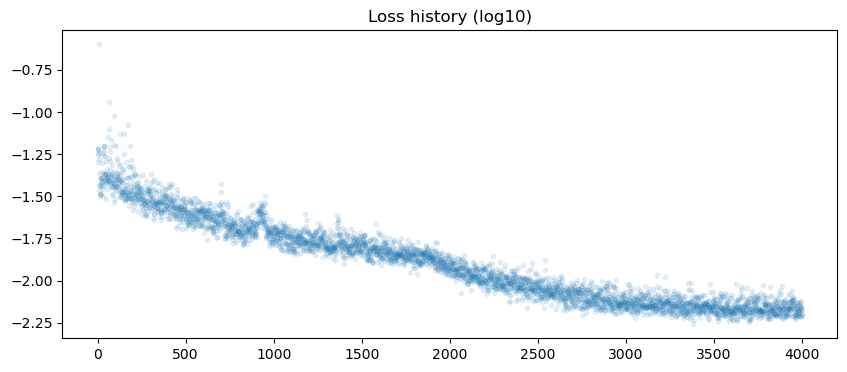

 step: 4001, log10(loss): -2.208CPU times: user 15min 57s, sys: 12.1 s, total: 16min 9s
Wall time: 15min 20s


In [19]:
%%time
# original torch conv layer initialization WITH weight decay

ca = CAModel().to(device)
train = Train(ca, seed.to(device), pad_target.to(device))

loss_log = train.train(n_steps=4001)

In [152]:
save_ca_model(ca, "persistent_1")

Saved model persistent_1 to disk


In [36]:
x0.shape

torch.Size([8, 72, 72, 16])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 678.04it/s]

batch (before/after):


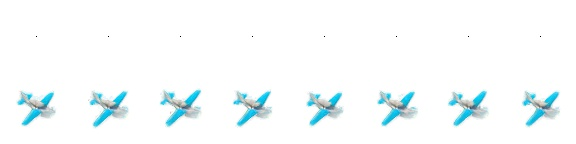

In [78]:
importlib.reload(sys.modules['original_utils'])
from original_utils import *
x = simulate_model(ca.to(device), x0.to(device), n_steps=195, device=device)

# Break

(1, 4, 72, 72) <class 'numpy.ndarray'>
(1, 72, 72, 4)


/tmp/ipykernel_3208623/4731981.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img.thumbnail((40,40), PIL.Image.ANTIALIAS)


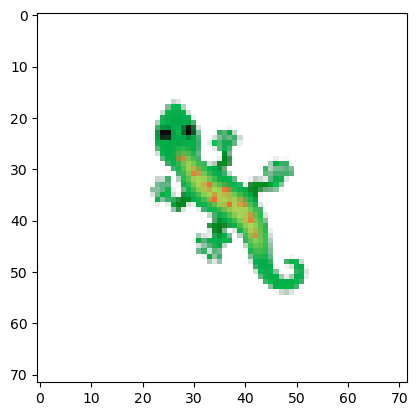

In [135]:
def get_dataset(k=16):
  r = requests.get('https://greydanus.github.io/files/lizard_1f98e.png')
  img = PIL.Image.open(io.BytesIO(r.content))  # get image: emoji_u1f98e (🦎)
  img.thumbnail((40,40), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0                  # convert image to NumPy array
  img *= img[..., 3:]                          # premultiply RGB by alpha
  img = img.transpose(2,0,1)[None,...]         # axes are [N, C, H, W]
  return {'y': np.pad(img, ((0,0),(0,0),(k,k),(k,k)))}  # pad image

y = get_dataset()
test_y = y['y']
print(test_y.shape, type(test_y))
y_reshaped = np.transpose(test_y, (0, 2, 3, 1))
print(y_reshaped.shape)
assert y_reshaped.shape == (1, 72, 72, 4)
plt.imshow(y_reshaped[0, ...])

In [94]:
# Implement the Neural Cellular Automata as a PyTorch module
class CA(nn.Module): 
  def __init__(self, state_dim=16, hidden_dim=128):
    super(CA, self).__init__()
    self.state_dim = state_dim
    self.update = nn.Sequential(nn.Conv2d(state_dim, 3*state_dim, 3, padding=1, groups=state_dim, bias=False),  # perceive
                                nn.Conv2d(3*state_dim, hidden_dim, 1),  # process perceptual inputs
                                nn.ReLU(),                              # nonlinearity
                                nn.Conv2d(hidden_dim, state_dim, 1))    # output a residual update
    self.update[-1].weight.data *= 0  # initial residual updates should be close to zero
    
    # First conv layer will use fixed Sobel filters to perceive neighbors
    identity = np.outer([0, 1, 0], [0, 1, 0])       # identity filter
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0      # Sobel x filter
    kernel = np.stack([identity, dx, dx.T], axis=0) # stack (identity, dx, dy) filters
    kernel = np.tile(kernel, [state_dim,1,1])       # tile over channel dimension
    self.update[0].weight.data[...] = torch.Tensor(kernel)[:,None,:,:]
    self.update[0].weight.requires_grad = False
  
  def forward(self, x, num_steps):
    alive_mask = lambda alpha: nn.functional.max_pool2d(alpha, 3, stride=1, padding=1) > 0.1
    frames = []
    for i in range(num_steps):
      alive_mask_pre = alive_mask(alpha=x[:,3:4])
      update_mask = torch.rand(*x.shape, device=x.device) > 0.5  # run a state update 1/2 of time
      x = x + update_mask * self.update(x)                       # state update!
      x = x * alive_mask_pre * alive_mask(alpha=x[:,3:4])        # a cell is either living or dead
      frames.append(x.clone())
    return torch.stack(frames) # axes: [N, B, C, H, W] where N is # of steps


In [149]:
def normalize_grads(model):  # makes training more stable, especially early on
  for p in model.parameters():
      p.grad = p.grad / (p.grad.norm() + 1e-8) if p.grad is not None else p.grad

def train(model, pad_target, n_steps=1001):
  model = model.to(device)  # put the model on GPU
  optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500], gamma=0.25)

  # target_rgba = torch.Tensor(pad_target['y']).to(device)  # put the target image on GPU
  target_rgba = torch.repeat_interleave(pad_target[None, ...], BATCH_SIZE, dim=0)
  target_rgba = pad_target[None, ...]
  target_rgba = target_rgba.permute(0, -1, 1, 2).contiguous()
  # print(f"target_rgba shape is {target_rgba.shape}")
  # assert target_rgba.shape == (1, 4, 72, 72)
                                            
  init_state = torch.zeros(BATCH_SIZE, CHANNEL_N, *target_rgba.shape[-2:]).to(device)

  # print(f"init_state is shape {init_state.shape}")

  init_state[...,init_state.shape[-2]//2,init_state.shape[-1]//2] = 1.  # initially, there is just one cell
  pool = init_state[:1].repeat(POOL_SIZE,1,1,1)
  
  # results = {'loss':[], 'tprev': [time.time()]}
  loss_log = []

  for step in range(n_steps):

    # prepare batch, perturb, and run forward pass
    if POOL_SIZE > 0:  # draw CAs from pool (if we have one)
      pool_ixs = np.random.randint(POOL_SIZE, size=[BATCH_SIZE])
      input_states = pool[pool_ixs]
    else:
      input_states = init_state
    # if args.perturb_n > 0:  # perturb CAs (if desired)
    #   perturb = make_circle_masks(args.perturb_n, *init_state.shape[-2:])[:, None, ...]
    #   input_states[-args.perturb_n:] *= perturb.to(args.device)

    # print(f'input states before model shape is {input_states.shape}')
    states = model(input_states, np.random.randint(64, 96, dtype=np.int32))  # forward pass
    final_rgba = states[-1,:, :4]  # grab rgba channels of last frame

    # compute loss and run backward pass
    mses = (target_rgba.unsqueeze(0)-final_rgba).pow(2)
    batch_mses = mses.view(BATCH_SIZE,-1).mean(-1)
    loss = batch_mses.mean()
    loss.backward() ; normalize_grads(model)
    optimizer.step() ; optimizer.zero_grad() ; scheduler.step()

    # update the pool (if we have one)
    if POOL_SIZE > 0:
      final_states = states[-1].detach()
      final_states[batch_mses.argmax()] = init_state[:1]
      pool[pool_ixs] = final_states

    # bookkeeping and logging
    # results['loss'].append(loss.item())
    loss_log.append(loss.item())
    if step % 100 == 0:

      # clear_output()
      # print(f"shape of input states is {input_states.shape} and of states is {states.shape}")
      visualize_x0 = input_states[...].detach().cpu().permute(0, 2, 3, 1)
      visualize_x = states[-1, ...].detach().cpu().permute(0, 2, 3, 1)

      # Visualize batch
      visualize_batch(visualize_x0, visualize_x, step)

      # Plot loss
      plot_loss(loss_log)

    print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss_log[-1])), end='')
        
      # print('step {}, dt {:.3f}s, loss {:.2e}, log10(loss) {:.2f}'\
      #     .format(step, time.time()-results['tprev'][-1], loss.item(), np.log10(loss.item())))
      # results['tprev'].append(time.time())

  # results['final_model'] = copy.deepcopy(model.cpu())
  # return results
  return loss_log

batch (before/after):


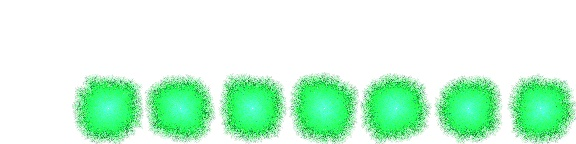

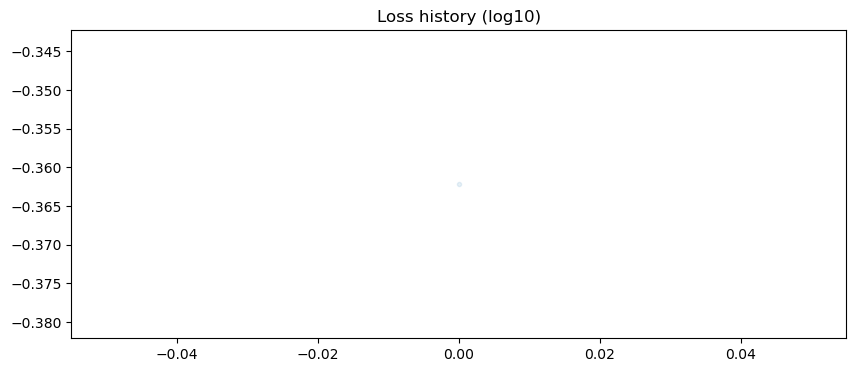

 step: 100, log10(loss): -1.314batch (before/after):


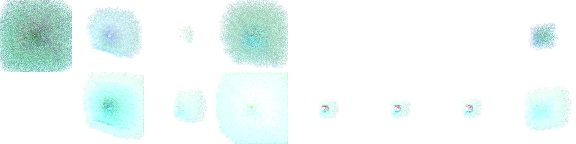

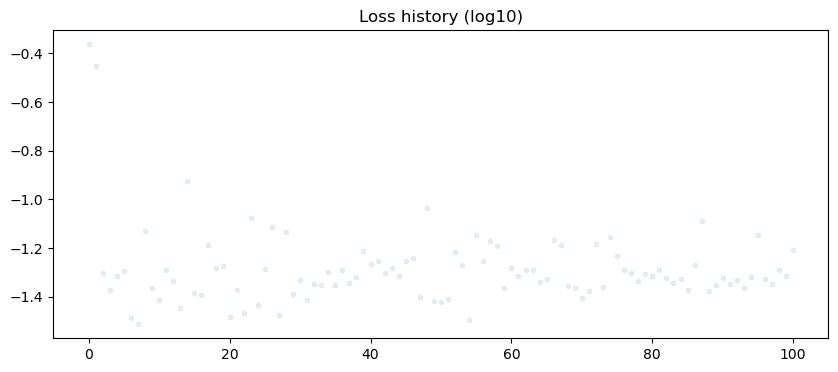

 step: 200, log10(loss): -1.565batch (before/after):


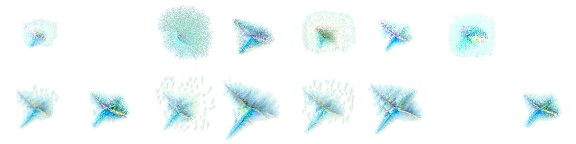

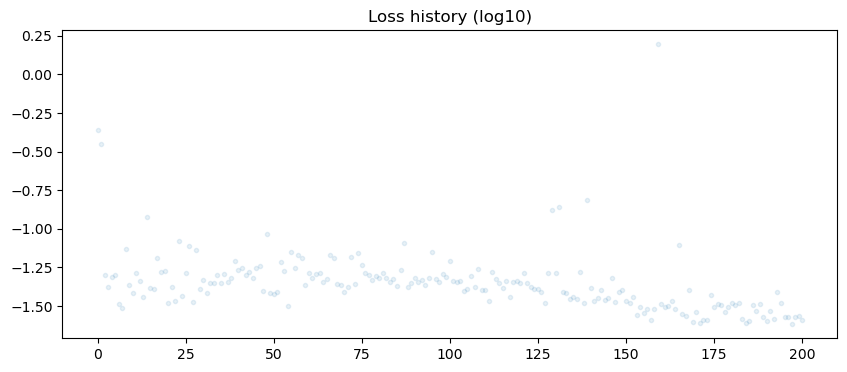

 step: 300, log10(loss): -1.535batch (before/after):


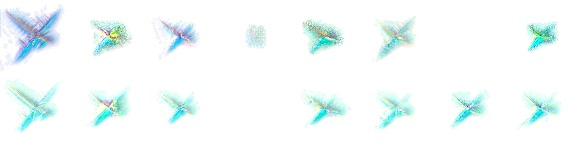

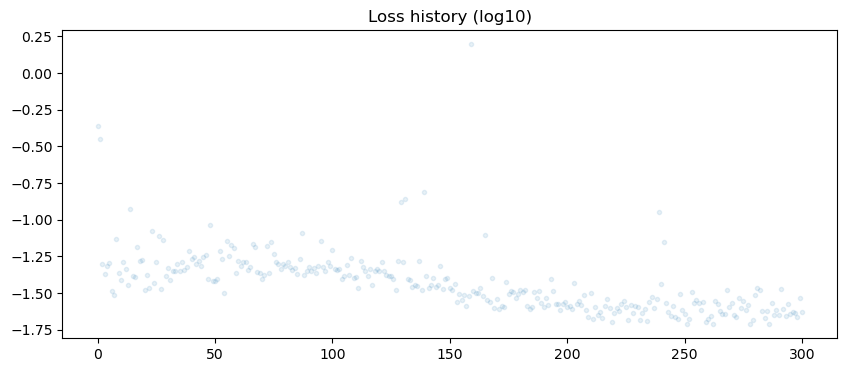

 step: 400, log10(loss): -1.777batch (before/after):


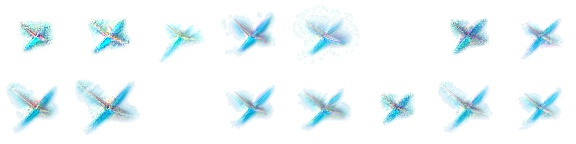

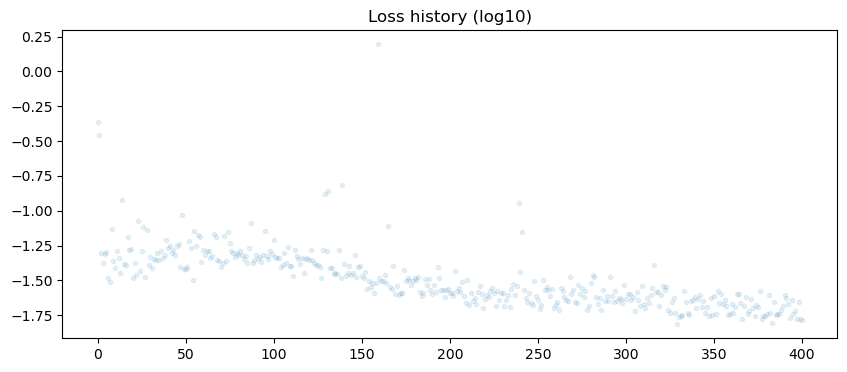

 step: 500, log10(loss): -1.809batch (before/after):


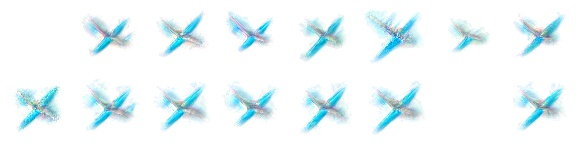

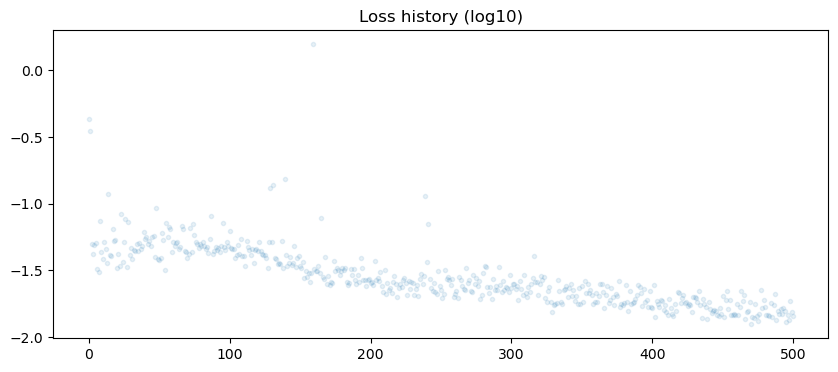

 step: 600, log10(loss): -1.925batch (before/after):


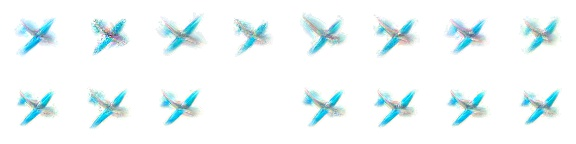

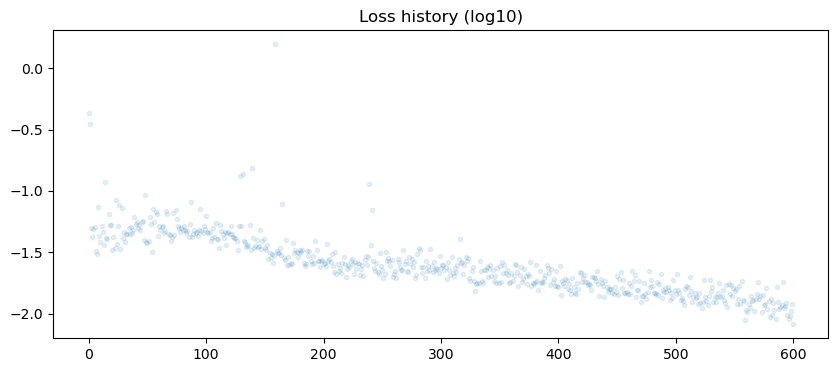

 step: 700, log10(loss): -2.114batch (before/after):


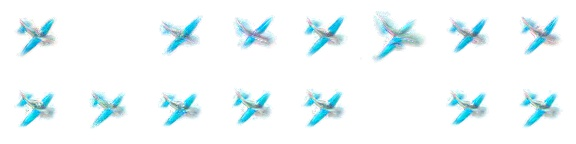

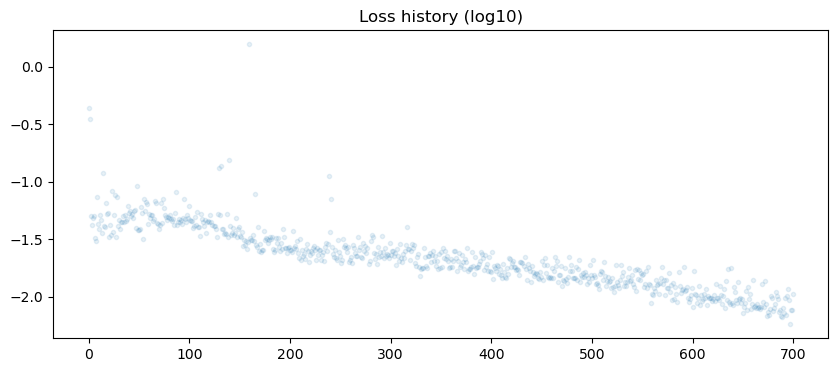

 step: 800, log10(loss): -2.221batch (before/after):


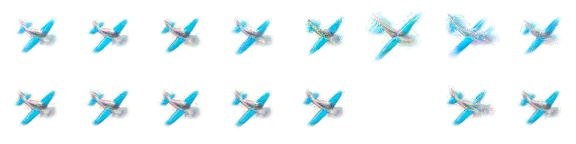

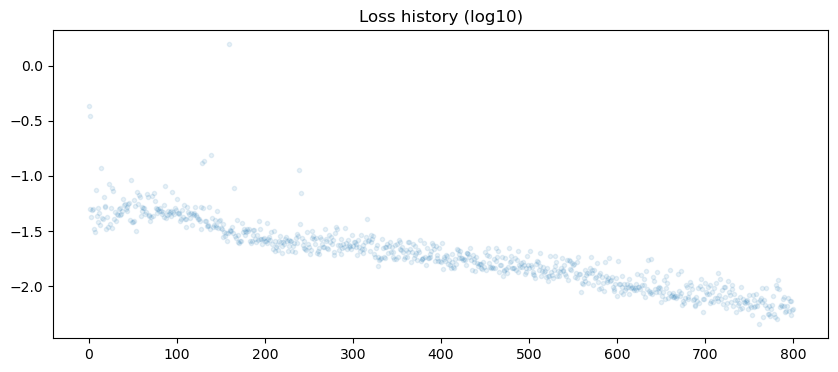

 step: 900, log10(loss): -2.363batch (before/after):


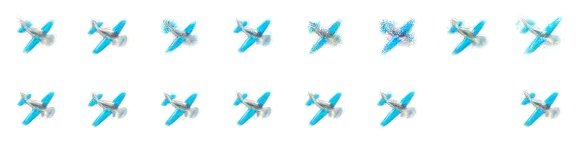

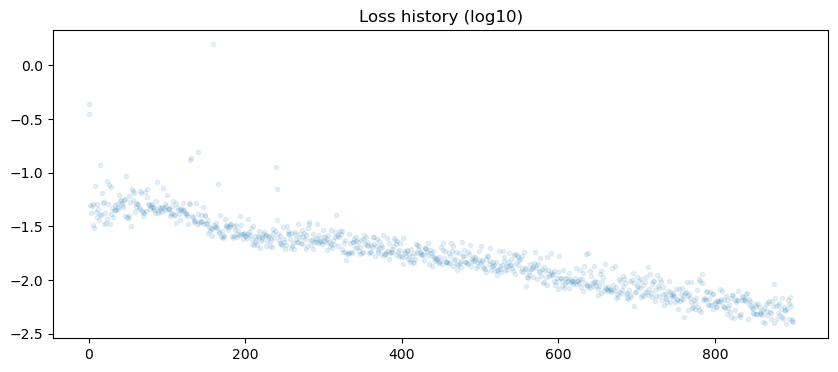

 step: 1000, log10(loss): -2.375batch (before/after):


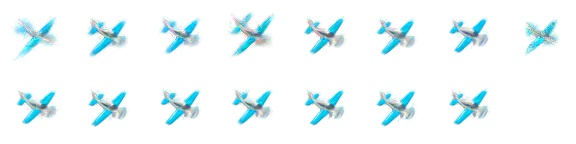

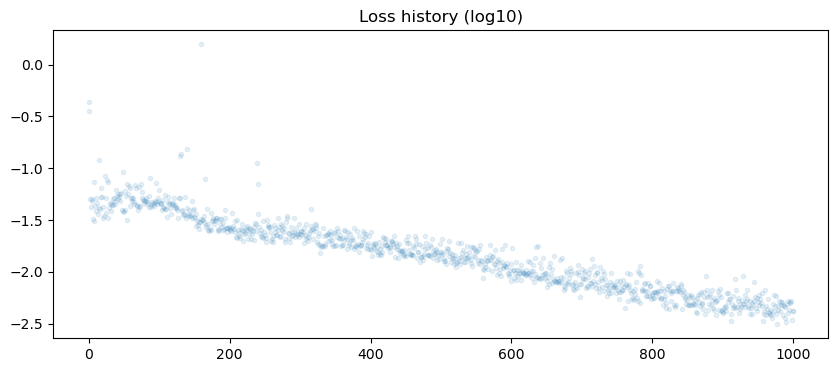

 step: 1100, log10(loss): -2.478batch (before/after):


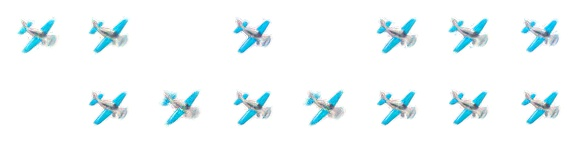

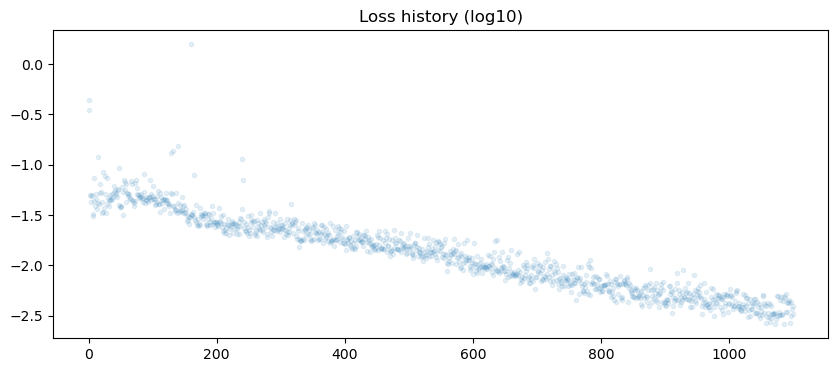

 step: 1200, log10(loss): -2.505batch (before/after):


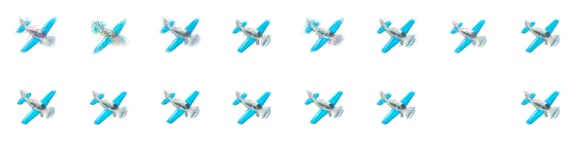

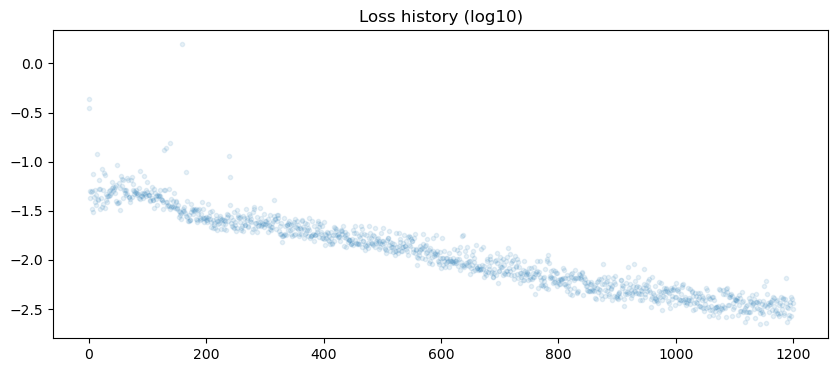

 step: 1300, log10(loss): -2.540batch (before/after):


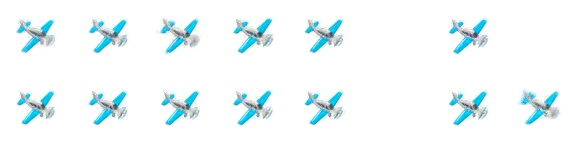

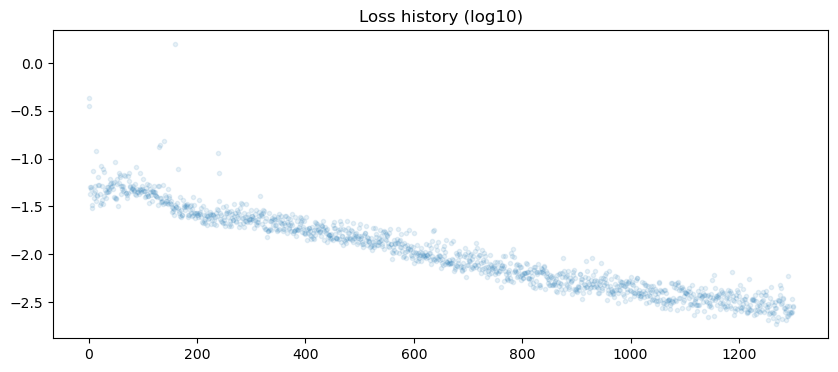

 step: 1400, log10(loss): -2.498batch (before/after):


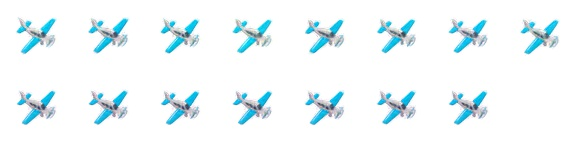

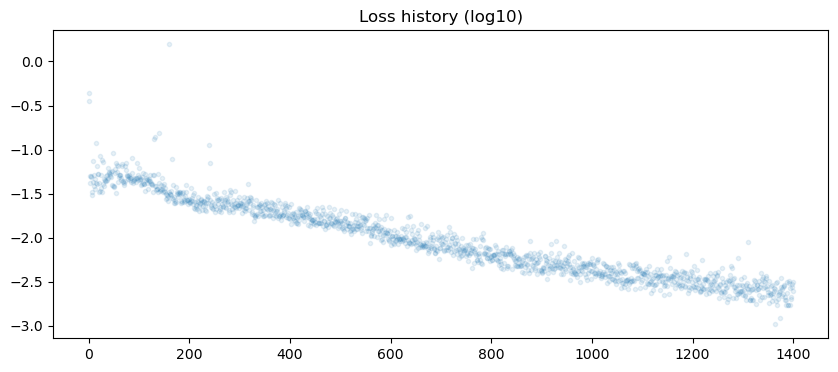

 step: 1500, log10(loss): -2.692batch (before/after):


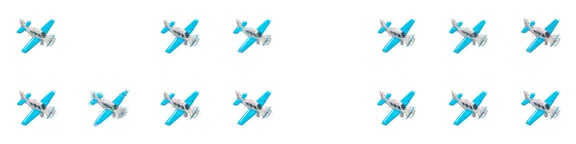

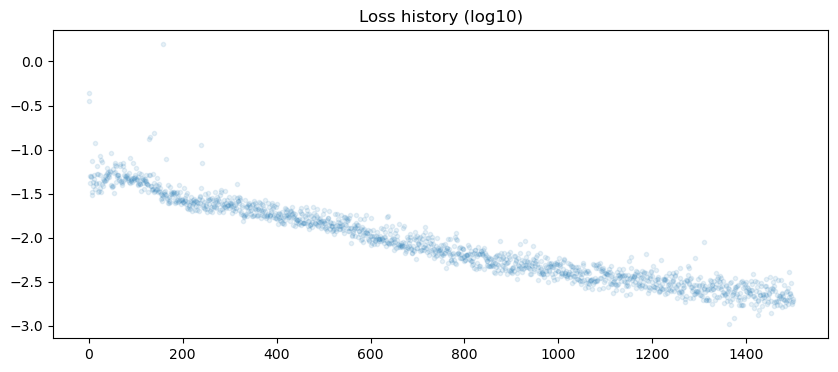

 step: 1600, log10(loss): -2.682batch (before/after):


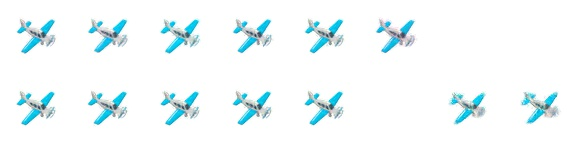

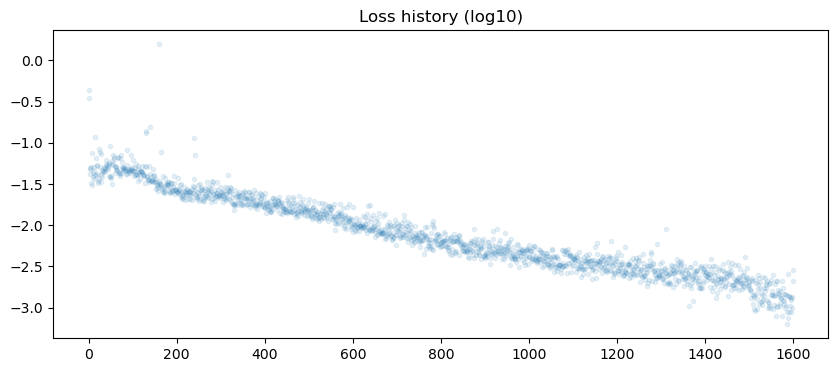

 step: 1700, log10(loss): -2.934batch (before/after):


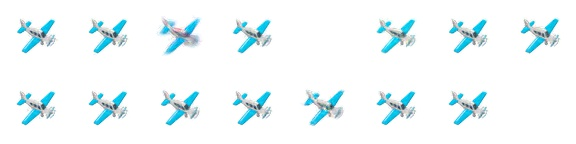

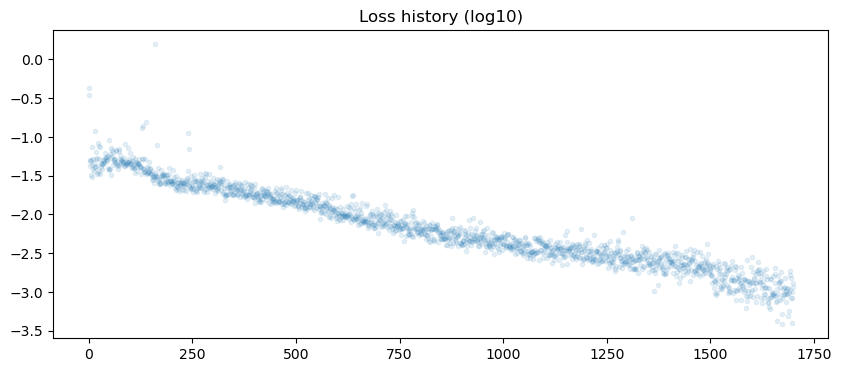

 step: 1783, log10(loss): -3.029

KeyboardInterrupt: 

In [150]:
other_ca_model1 = CA()
other_loss_log1 = train(other_ca_model1.to(device), pad_target.to(device), n_steps=2001) 

/tmp/ipykernel_3208623/4731981.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img.thumbnail((40,40), PIL.Image.ANTIALIAS)


target_rgba shape is torch.Size([1, 4, 72, 72])
batch (before/after):


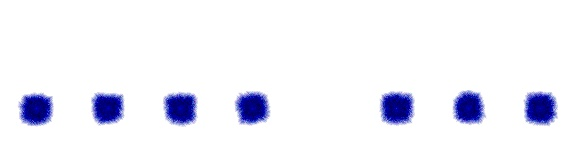

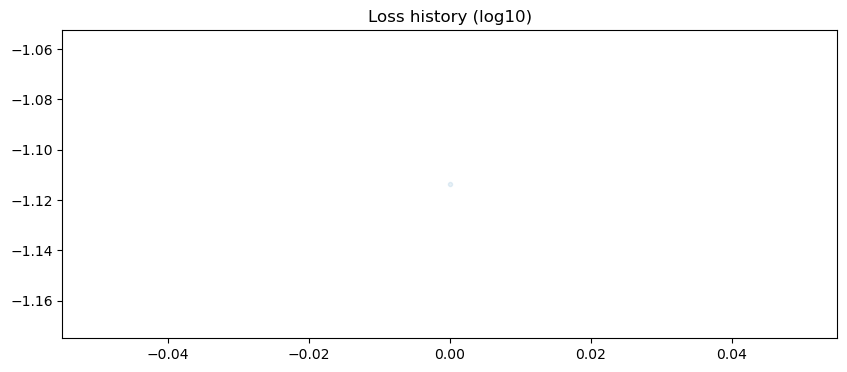

 step: 100, log10(loss): -1.969batch (before/after):


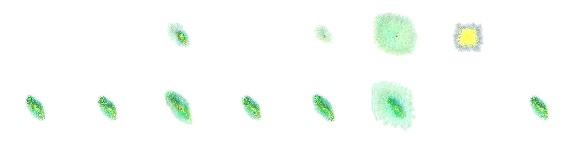

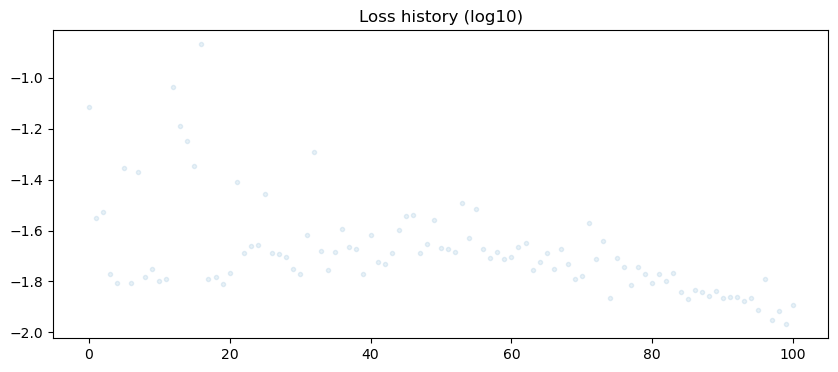

 step: 200, log10(loss): -2.044batch (before/after):


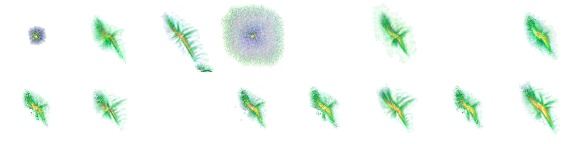

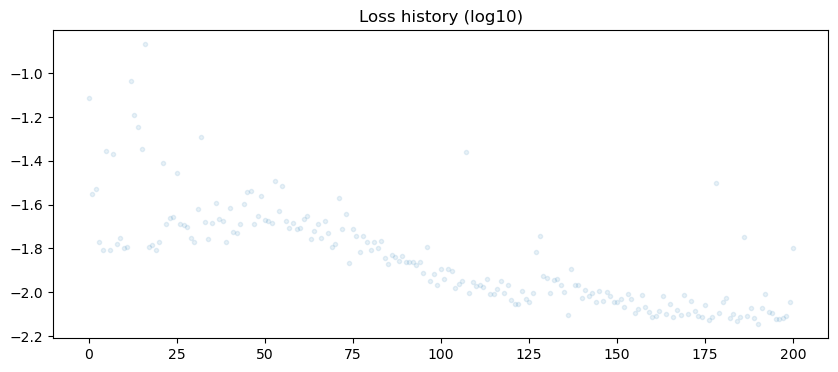

 step: 300, log10(loss): -2.303batch (before/after):


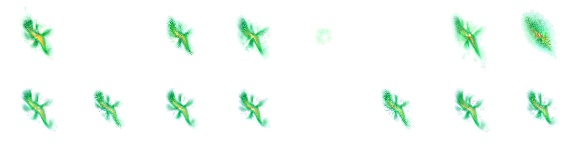

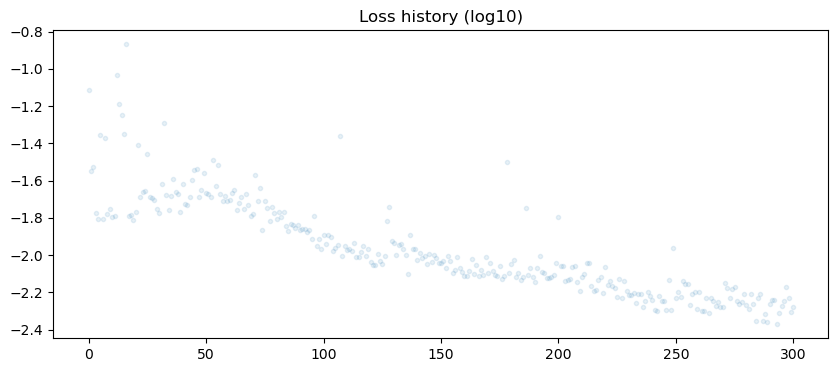

 step: 400, log10(loss): -2.418batch (before/after):


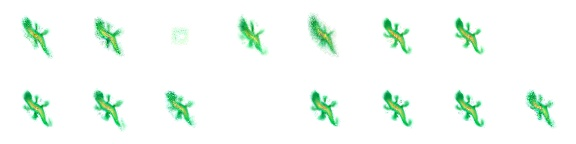

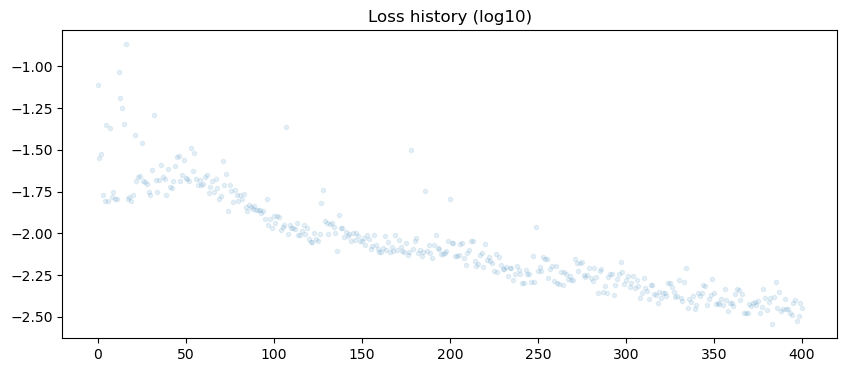

 step: 500, log10(loss): -2.606batch (before/after):


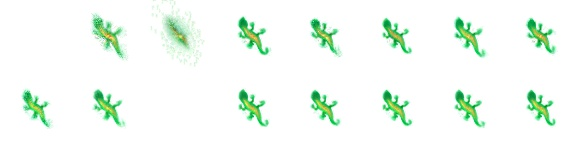

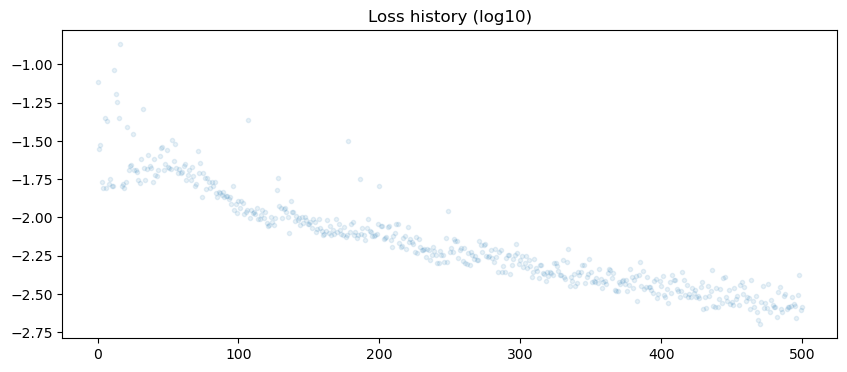

 step: 600, log10(loss): -2.642batch (before/after):


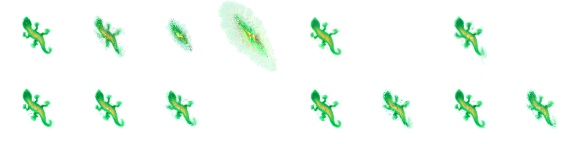

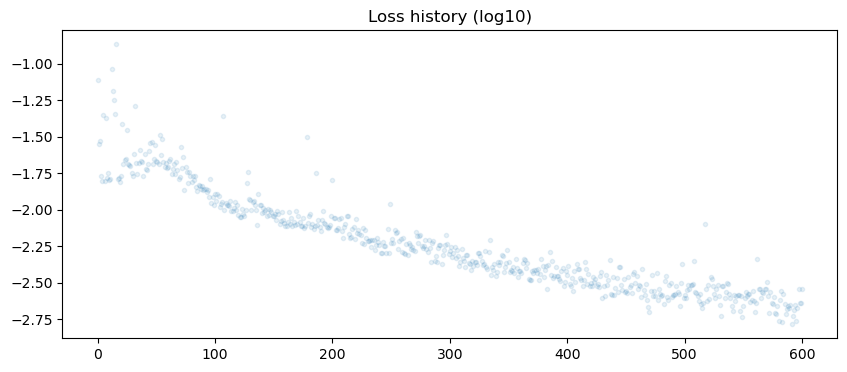

 step: 700, log10(loss): -2.760batch (before/after):


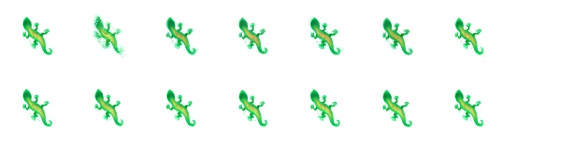

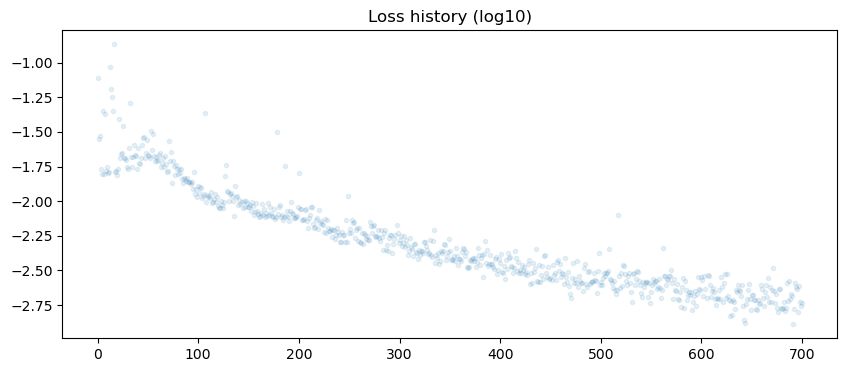

 step: 800, log10(loss): -2.848batch (before/after):


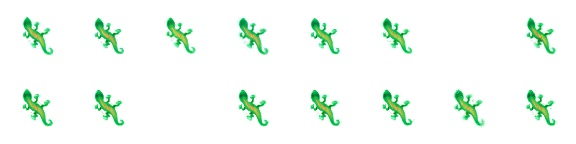

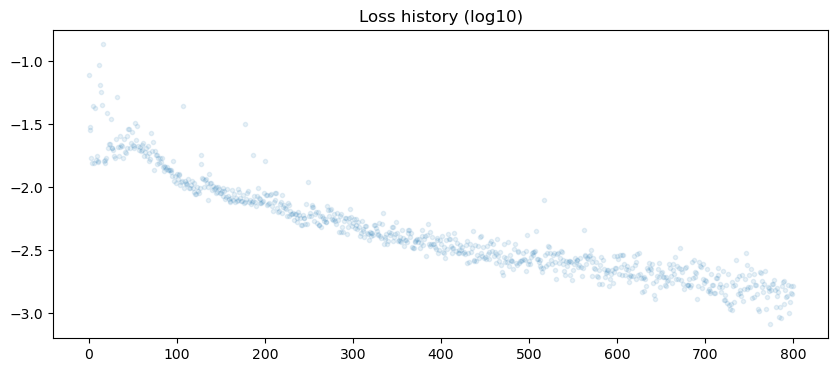

 step: 900, log10(loss): -2.937batch (before/after):


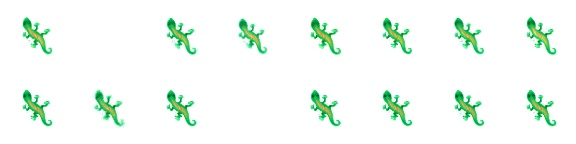

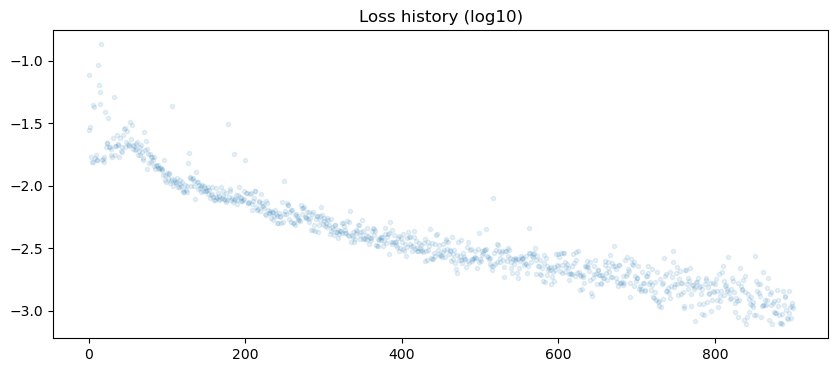

 step: 1000, log10(loss): -2.926batch (before/after):


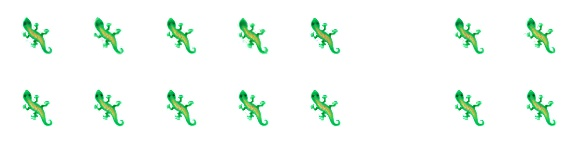

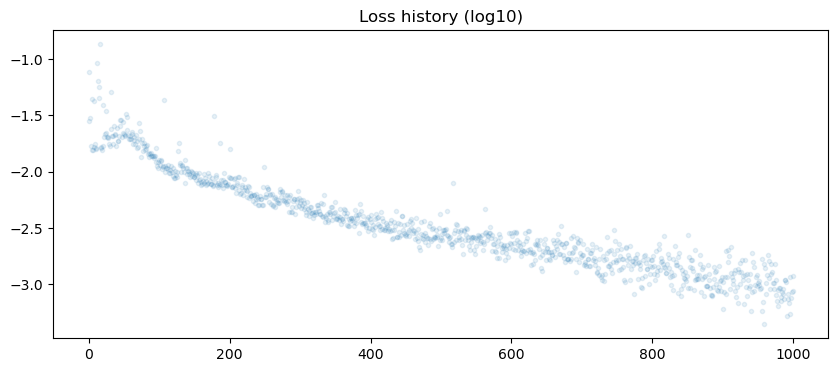

 step: 1100, log10(loss): -3.056batch (before/after):


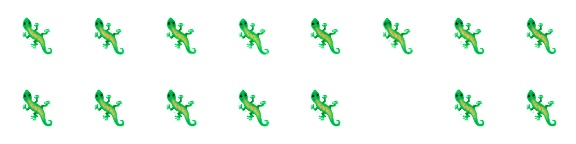

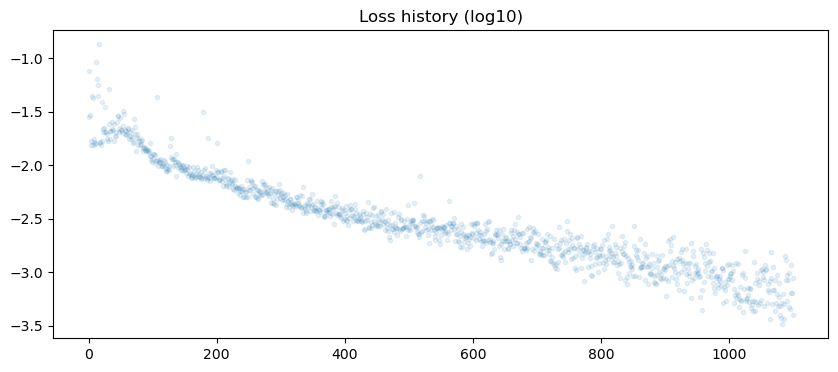

 step: 1200, log10(loss): -3.439batch (before/after):


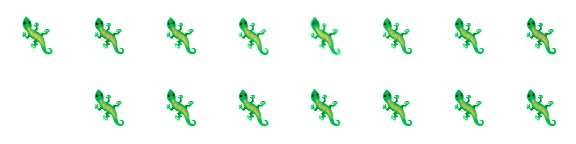

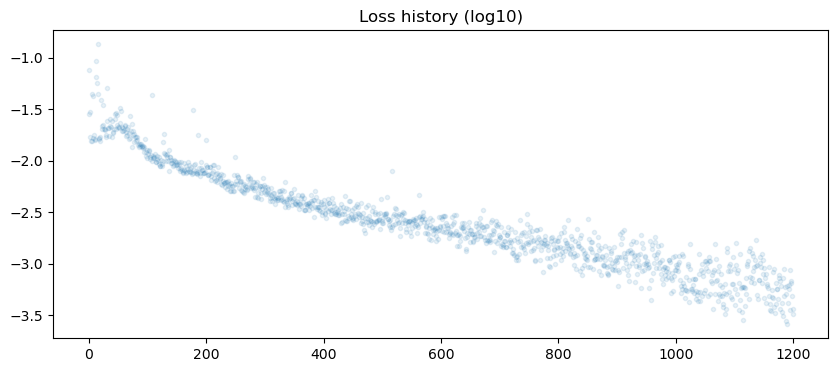

 step: 1300, log10(loss): -3.602batch (before/after):


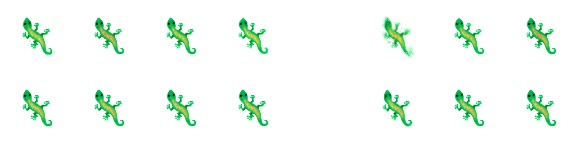

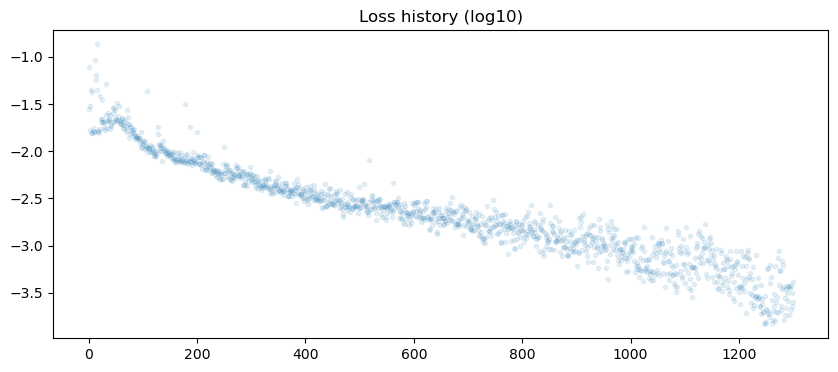

 step: 1400, log10(loss): -3.373batch (before/after):


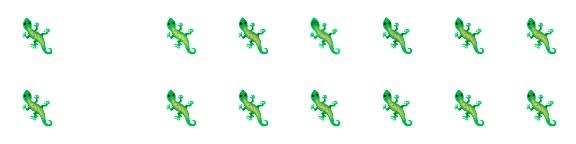

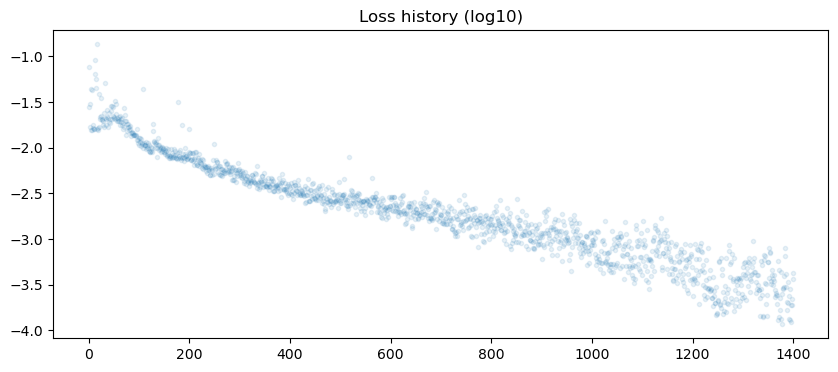

 step: 1500, log10(loss): -3.621batch (before/after):


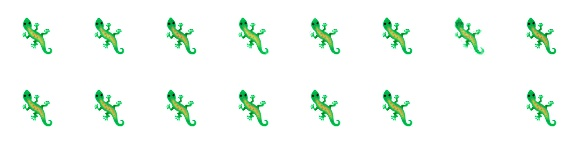

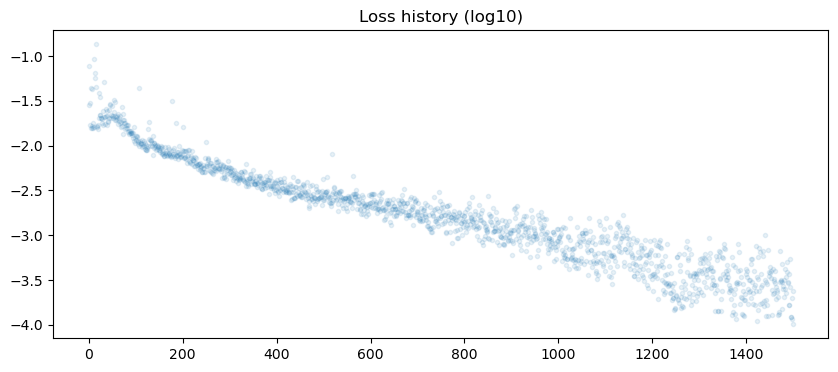

 step: 1600, log10(loss): -3.297batch (before/after):


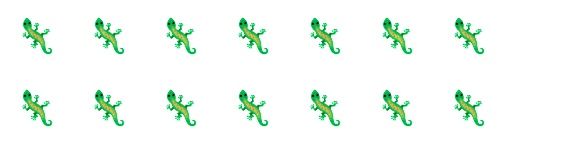

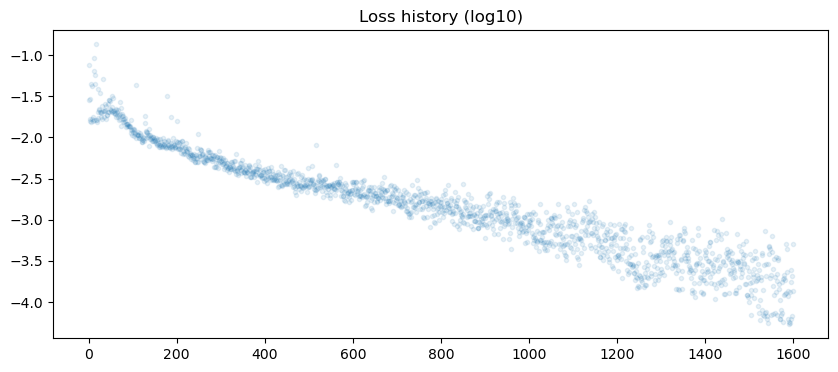

 step: 1700, log10(loss): -3.880batch (before/after):


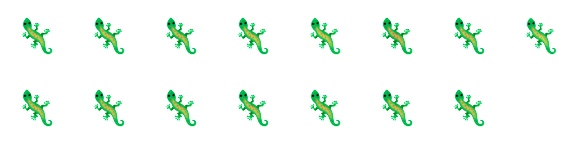

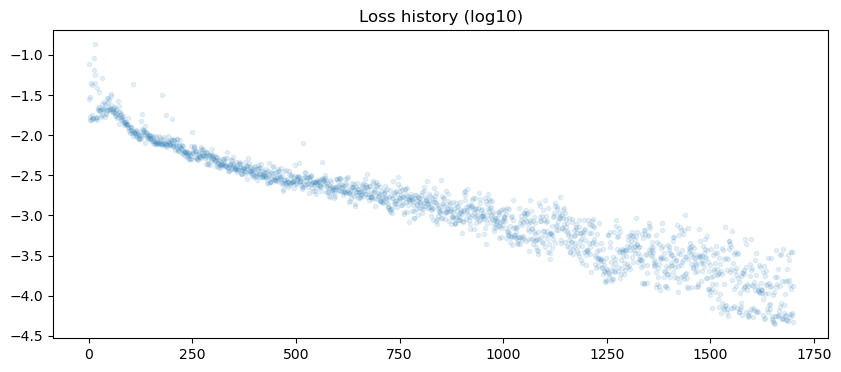

 step: 1800, log10(loss): -4.027batch (before/after):


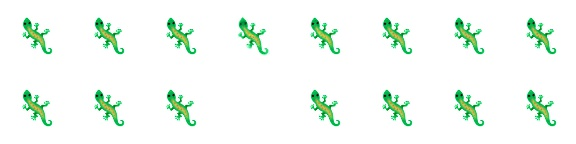

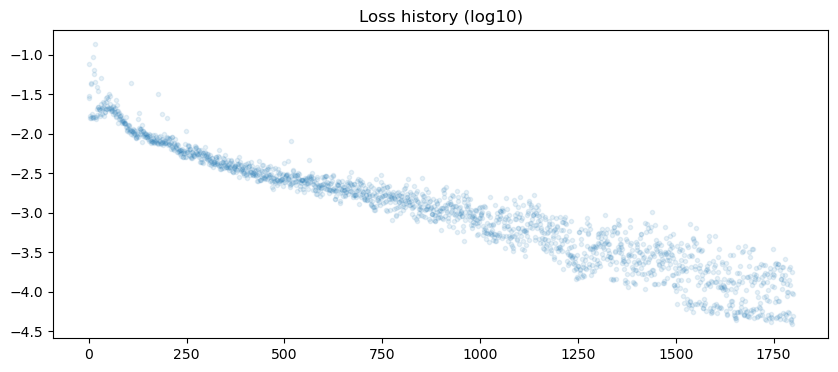

 step: 1900, log10(loss): -4.437batch (before/after):


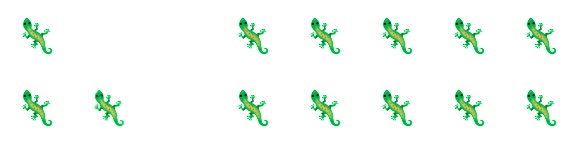

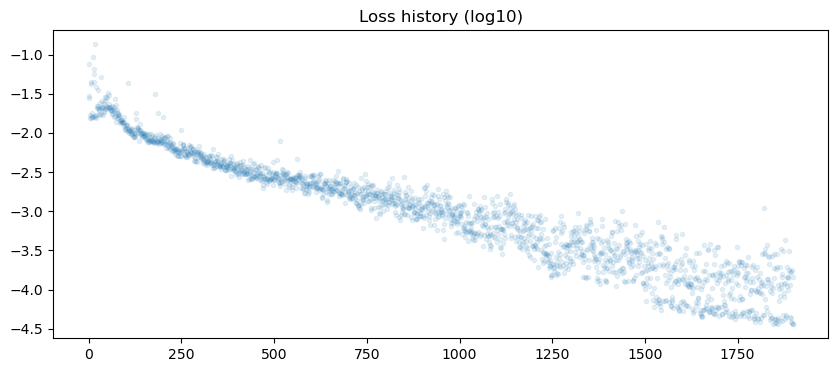

 step: 1981, log10(loss): -3.827

KeyboardInterrupt: 

In [136]:
other_ca_model = CA()
# other_loss_log = train(other_ca_model.to(device), pad_target.to(device), n_steps=2001) 
other_loss_log = train(other_ca_model.to(device), get_dataset(), n_steps=2001) 

In [ ]:
  model = CA(args.state_dim, args.hidden_dim)
  results = train(model, args, data=get_dataset())

In [93]:
pad_target.shape

torch.Size([72, 72, 4])

In [120]:
# Neural CA | Sam Greydanus | 2020
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
import time, PIL.Image, io, requests, copy

def get_dataset(k=16):
  r = requests.get('https://greydanus.github.io/files/lizard_1f98e.png')
  img = PIL.Image.open(io.BytesIO(r.content))  # get image: emoji_u1f98e (🦎)
  img.thumbnail((40,40), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0                  # convert image to NumPy array
  img *= img[..., 3:]                          # premultiply RGB by alpha
  img = img.transpose(2,0,1)[None,...]         # axes are [N, C, H, W]
  return {'y': np.pad(img, ((0,0),(0,0),(k,k),(k,k)))}  # pad image

def make_circle_masks(n, h, w):
  x = torch.linspace(-1.0, 1.0, w)[None, None, :]
  y = torch.linspace(-1.0, 1.0, h)[None, :, None]
  center = torch.rand(2, n, 1, 1)-.5
  r = 0.3 * torch.rand(n, 1, 1) + 0.1
  x, y = (x-center[0])/r, (y-center[1])/r
  return 1-(x*x+y*y < 1.0).float()  # mask is OFF in circle

# Implement the Neural Cellular Automata as a PyTorch module
class CA(nn.Module): 
  def __init__(self, state_dim=16, hidden_dim=128):
    super(CA, self).__init__()
    self.state_dim = state_dim
    self.update = nn.Sequential(nn.Conv2d(state_dim, 3*state_dim, 3, padding=1, groups=state_dim, bias=False),  # perceive
                                nn.Conv2d(3*state_dim, hidden_dim, 1),  # process perceptual inputs
                                nn.ReLU(),                              # nonlinearity
                                nn.Conv2d(hidden_dim, state_dim, 1))    # output a residual update
    self.update[-1].weight.data *= 0  # initial residual updates should be close to zero
    
    # First conv layer will use fixed Sobel filters to perceive neighbors
    identity = np.outer([0, 1, 0], [0, 1, 0])       # identity filter
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0      # Sobel x filter
    kernel = np.stack([identity, dx, dx.T], axis=0) # stack (identity, dx, dy) filters
    kernel = np.tile(kernel, [state_dim,1,1])       # tile over channel dimension
    self.update[0].weight.data[...] = torch.Tensor(kernel)[:,None,:,:]
    self.update[0].weight.requires_grad = False
  
  def forward(self, x, num_steps):
    alive_mask = lambda alpha: nn.functional.max_pool2d(alpha, 3, stride=1, padding=1) > 0.1
    frames = []
    for i in range(num_steps):
      alive_mask_pre = alive_mask(alpha=x[:,3:4])
      update_mask = torch.rand(*x.shape, device=x.device) > 0.5  # run a state update 1/2 of time
      x = x + update_mask * self.update(x)                       # state update!
      x = x * alive_mask_pre * alive_mask(alpha=x[:,3:4])        # a cell is either living or dead
      frames.append(x.clone())
    return torch.stack(frames) # axes: [N, B, C, H, W] where N is # of steps

def normalize_grads(model):  # makes training more stable, especially early on
  for p in model.parameters():
      p.grad = p.grad / (p.grad.norm() + 1e-8) if p.grad is not None else p.grad

def train(model, args, data):
  model = model.to(args.device)  # put the model on GPU
  optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
  scheduler = MultiStepLR(optimizer, milestones=args.milestones, gamma=args.gamma)

  target_rgba = torch.Tensor(data['y']).to(args.device)  # put the target image on GPU
  init_state = torch.zeros(args.batch_size, args.state_dim, *target_rgba.shape[-2:]).to(args.device)
  init_state[...,init_state.shape[-2]//2,init_state.shape[-1]//2] = 1.  # initially, there is just one cell
  pool = init_state[:1].repeat(args.pool_size,1,1,1)
  
  results = {'loss':[], 'tprev': [time.time()]}
  for step in range(args.total_steps+1):

    # prepare batch, perturb, and run forward pass
    if args.pool_size > 0:  # draw CAs from pool (if we have one)
      pool_ixs = np.random.randint(args.pool_size, size=[args.batch_size])
      input_states = pool[pool_ixs]
    else:
      input_states = init_state
    if args.perturb_n > 0:  # perturb CAs (if desired)
      perturb = make_circle_masks(args.perturb_n, *init_state.shape[-2:])[:, None, ...]
      input_states[-args.perturb_n:] *= perturb.to(args.device)

    states = model(input_states, np.random.randint(*args.num_steps))  # forward pass
    final_rgba = states[-1,:, :4]  # grab rgba channels of last frame

    # compute loss and run backward pass
    mses = (target_rgba.unsqueeze(0)-final_rgba).pow(2)
    batch_mses = mses.view(args.batch_size,-1).mean(-1)
    loss = batch_mses.mean()
    loss.backward() ; normalize_grads(model)
    optimizer.step() ; optimizer.zero_grad() ; scheduler.step()

    # update the pool (if we have one)
    if args.pool_size > 0:
      final_states = states[-1].detach()
      final_states[batch_mses.argmax()] = init_state[:1]
      pool[pool_ixs] = final_states

    # bookkeeping and logging
    results['loss'].append(loss.item())
    if step % args.print_every == 0:
      print('step {}, dt {:.3f}s, loss {:.2e}, log10(loss) {:.2f}'\
          .format(step, time.time()-results['tprev'][-1], loss.item(), np.log10(loss.item())))
      results['tprev'].append(time.time())

  results['final_model'] = copy.deepcopy(model.cpu())
  return results


# Organize hyperparameters in a sane way
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
def get_args(as_dict=False):
  arg_dict = {'state_dim': 16,        # first 4 are rgba, rest are latent
              'hidden_dim': 128,
              'num_steps': [64, 96],
              'pool_size': 0,         # pool of persistent CAs (defaults are 0 and 1000)
              'perturb_n': 0,         # num. of CAs to perturb (defaults are 0 and 3)
              'batch_size': 8,
              'learning_rate': 2e-3, 
              'milestones': [1500],   # lr scheduler milestones
              'gamma': 0.25,          # lr scheduler gamma
              'print_every': 100,
              'total_steps': 2000,
              'device': 'cuda',       # options are {"cpu", "cuda"}
              'seed': 42}             # the meaning of life (for these little guys)
  return arg_dict if as_dict else ObjectView(arg_dict)